In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pred = pd.read_csv("Final Submission Models/submissions/final_submission.csv")

## Determine Counties with Highest Absolute/Percentage Error

In [3]:
def pinball_loss(y_true, y_pred, quantile = 0.5):
    delta = y_true - y_pred
    # Compute loss for underestimates. 
    loss_above = np.sum(delta[delta > 0]) * (quantile)
    # Compute loss for overestimates.
    loss_below = np.sum(-1 * delta[delta < 0]) * (1 - quantile)
    return (loss_above + loss_below) / len(y_true)

In [4]:
def score_one_county(submission):
    nyt_dates = ['5/26/20', '5/27/20', '5/28/20', '5/29/20', '5/30/20', '5/31/20', '6/1/20', '6/2/20', '6/3/20']
    submission_dates = ['2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03']

    submission_to_nyt_date = {}
    for i, date in enumerate(submission_dates):
        submission_to_nyt_date[date] = nyt_dates[i]

    # Compute the submission predictions
    submission = submission[submission['id'].str.contains(('|'.join(submission_dates)))]

    # Compute the actual results
    deaths = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")
    deaths = deaths[['date', 'fips', 'deaths']]
    deaths = deaths[deaths['date'].str.contains(('|'.join(submission_dates)))]

    # Generate a numpy array of the actual results in the same order
    # as the submission. If a county has no reported deaths, we assume
    # that is has 0.

    truth = np.empty(len(submission['id'].values))
    for i, submission_id in enumerate(submission['id'].values):
        split_id = submission_id.split('-')
        # Extract the FIPS and date from the id column of the submission
        FIPS = int(split_id[-1])
        date = '-'.join(split_id[:-1])

        # Extract the relevant row of the nyt deaths data
        df = deaths.loc[(deaths['fips'] == FIPS) & (deaths['date'] == date)]

        # Set the truth numpy array accordingly
        if df.empty:
            truth[i] = 0
        else:
            truth[i] = df['deaths']

    # Compute the pinball score using the given dates, submission, and
    # truth values
    score = 0.0
    for column in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
        score = score + pinball_loss(truth, submission[str(column)].values, quantile = column / 100.0)

    score = score/9.0

    return score

In [5]:
fips_list = pd.read_csv("data/us/processing_data/fips_key.csv", encoding="cp1252")
fips_list.rename(columns={"FIPS": "fips"}, inplace=True)

In [6]:
pred["fips"] = 0
pred["date"] = ""

for i, row in pred.iterrows():
    fips = int(row["id"][11:])
    date = row["id"][:10]
    pred.at[i, "fips"] = fips
    pred.at[i, "date"] = date

In [7]:
pred.head()

,id,10,20,30,40,50,60,70,80,90,fips,date
0,2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10001,2020-04-01
1,2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10003,2020-04-01
2,2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10005,2020-04-01
3,2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001,2020-04-01
4,2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1003,2020-04-01


In [8]:
fipss = []
losses = []
for i, row in fips_list.iterrows():
    cdata = pred.loc[pred["fips"] == row["fips"]]
    if len(cdata) > 0:
        losses.append(score_one_county(cdata))
        fipss.append(row["fips"])
    else: print("No predictions for", str(row["fips"]))
    
losses = pd.DataFrame(data={"fips":fipss, "loss":losses})

In [26]:
losses["population"] = 0
losses["percentage"] = 0.0
losses.rename(columns={"loss":"absolute"}, inplace=True)

In [29]:
population = pd.read_csv("data/us/demographics/county_populations.csv")

for i, row in losses.iterrows():
    fips = row["fips"]
    pop = population.loc[population["FIPS"] == fips]["total_pop"]
    if len(pop) > 0:
        losses.at[i, "population"] = pop
        losses.at[i, "percentage"] = row["absolute"] / pop

In [30]:
losses.sort_values("absolute", ascending=False).head(20)

,fips,absolute,population,percentage
2332,44007,9.777778,633704,1.542957e-05
619,17031,8.562963,5238541,1.634608e-06
1875,36061,4.734568,1653877,2.862709e-06
213,6037,4.560494,10105722,4.512784e-07
3075,55013,3.666667,15239,2.406107e-04
1326,26163,3.503704,1763822,1.986427e-06
1235,25009,3.188889,775860,4.110134e-06
370,12086,2.918519,2702602,1.079892e-06
1593,29189,2.854321,999539,2.855637e-06
2312,42101,2.638272,1569657,1.680795e-06


In [31]:
losses.sort_values("percentage", ascending=False).head(20)

,fips,absolute,population,percentage
3075,55013,3.666667,15239,0.000241
2593,48103,0.277778,4836,0.000057
1535,29075,0.222222,6688,0.000033
1044,21077,0.277778,8652,0.000032
1021,21031,0.388889,12735,0.000031
2617,48151,0.111111,3875,0.000029
2942,51570,0.500000,17582,0.000028
413,13037,0.166667,6503,0.000026
11,1023,0.333333,13188,0.000025
2902,51131,0.288889,11998,0.000024


## Plot Predictions and Actual Data

In [112]:
nyt_data = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")

In [128]:
f = 6073

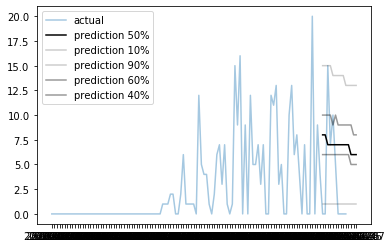

In [129]:
actual = nyt_data.loc[nyt_data["fips"] == f]

fig, ax = plt.subplots()
ax.plot('date', 'deaths', data=actual, label="actual", alpha=0.4)
ax.plot('date', '50', data=pred.loc[pred["fips"] == f][54:68], label="prediction 50%", c="black")
ax.plot('date', '10', data=pred.loc[pred["fips"] == f][54:68], label="prediction 10%", c="black", alpha=0.2)
ax.plot('date', '90', data=pred.loc[pred["fips"] == f][54:68], label="prediction 90%", c="black", alpha=0.2)
ax.plot('date', '60', data=pred.loc[pred["fips"] == f][54:68], label="prediction 60%", c="black", alpha=0.4)
ax.plot('date', '40', data=pred.loc[pred["fips"] == f][54:68], label="prediction 40%", c="black", alpha=0.4)
plt.legend()
plt.show()

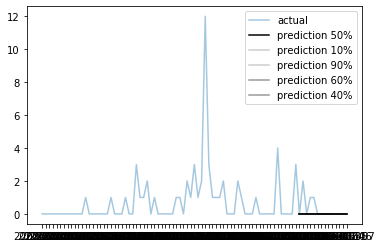

In [130]:
f = 45045

actual = nyt_data.loc[nyt_data["fips"] == f]

fig, ax = plt.subplots()
ax.plot('date', 'deaths', data=actual, label="actual", alpha=0.4)
ax.plot('date', '50', data=pred.loc[pred["fips"] == f][54:68], label="prediction 50%", c="black")
ax.plot('date', '10', data=pred.loc[pred["fips"] == f][54:68], label="prediction 10%", c="black", alpha=0.2)
ax.plot('date', '90', data=pred.loc[pred["fips"] == f][54:68], label="prediction 90%", c="black", alpha=0.2)
ax.plot('date', '60', data=pred.loc[pred["fips"] == f][54:68], label="prediction 60%", c="black", alpha=0.4)
ax.plot('date', '40', data=pred.loc[pred["fips"] == f][54:68], label="prediction 40%", c="black", alpha=0.4)
plt.legend()
plt.show()

In [91]:
predictions1 = pd.read_csv("Final Submission Models/submissions/arima_model_5-24.csv")
predictions2 = pd.read_csv("Final Submission Models/submissions/arima_residuals_5-24.csv")
predictions3 = pd.read_csv("Final Submission Models/submissions/benchmark_5-24.csv")
predictions4 = pd.read_csv("Final Submission Models/submissions/case_model_5-24.csv")
predictions5 = pd.read_csv("Final Submission Models/submissions/delphi_5-24.csv")
predictions6 = pd.read_csv("Final Submission Models/submissions/historian_model_5-24.csv")
predictions7 = pd.read_csv("Final Submission Models/submissions/imperial_model_5-24.csv")
predictions8 = pd.read_csv("Final Submission Models/submissions/rnn_residuals_5-24.csv")
predictions9 = pd.read_csv("Final Submission Models/submissions/svm_5-24.csv")

In [92]:
fips = 55013
date = "2020-06-01"

In [93]:
# Query to access the value in any dataframe
query = "id==" + "\"" + date + "-" + str(fips) + "\""

arima            = list(predictions1.query(query).values[0])[5]
arima_residuals  = list(predictions2.query(query).values[0])[5]
benchmark        = list(predictions3.query(query).values[0])[5]

case             = list(predictions4.query(query).values[0])[5]

# Impose guards against extreme upper outliers
case = min(20, case)

delphi           = list(predictions5.query(query).values[0])[5]

historian        = list(predictions6.query(query).values[0])[5]

# Impose guards against extreme upper outliers
historian = min(20, historian)

imperial         = list(predictions7.query(query).values[0])[5]
rnn_residuals    = list(predictions8.query(query).values[0])[5]
svm              = list(predictions9.query(query).values[0])[5]
svm = min(20, svm)

quantiles = []

In [94]:
median_pred = arima * 0.2 + arima_residuals * 0.2 + benchmark * 0.1 + delphi * 0.2 + rnn_residuals * 0.1 + svm * 0.2

In [95]:
median_pred

nan

In [105]:
min(10, median_pred)

10

## Finding Counties With Initial Similarities that Diverge

In [106]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans

In [108]:
class Covid_DTW:
    def __init__(self, death_df, population_df, fips_df, county_to_cluster, cluster_to_counties):
        """
        death_df should have columns fips, date, and deaths
        population_df should have columns fips, population
        fips_df should have coulumn fips
        """
        self.data = death_df
        self.pop = population_df
        self.fips = fips_df
        self.last_date = None
        self.co_cl = county_to_cluster
        self.cl_co = cluster_to_counties
        self.num_found_fit = 0
    
    def get_best_fit(self, target, target_county, dist_func, overlay_window, test_per, pred_per, death_lbound, log=True):        
        best_idx, best_fips, best_dist = -1, -1, float("inf")
        target_idx = len(target["dates"]) - overlay_window - test_per
        
        cluster = self.co_cl[str(target_county)]
        cluster_fips = self.cl_co[cluster]
        
        for county in cluster_fips:
            try: 
                if (county == target_county): continue

                if log: print("Testing best fit for " + str(target_county) + " on " + str(county) + "...", end='\r', flush=True)
                c_data = self.data.loc[self.data["fips"] == int(county)]

                c = {"dates": [], "deaths": []}
                c_pop = int(self.pop.loc[self.pop["fips"] == int(county)]["population"])
                cum_deaths = 0
                for idx, row in c_data.iterrows():
                    c["dates"].append(row["date"])
                    c["deaths"].append(row["deaths"] / c_pop)
                    cum_deaths += row["deaths"]

                #print(c["dates"])

                if cum_deaths <= death_lbound: continue

                c_df = pd.DataFrame(data=c)
                c_start = c_df.loc[c_df["deaths"] > 5e-6].first_valid_index()
                if (c_start == None): continue

                for j in range(c_start, len(c["dates"]) - test_per, 1):
                    if target_idx - j < pred_per + test_per: continue
                    distance, path = fastdtw(np.array(target["deaths"][target_idx:target_idx+overlay_window]), np.array(c["deaths"][j:j+overlay_window]), dist=dist_func)
                    if distance < best_dist:
                        best_idx = j
                        best_fips = county
                        best_dist = distance
                        best_path = path
                        
            except TypeError as e:
                continue
        
        return best_idx, int(best_fips), best_dist

In [109]:
def cluster_counties(num_clusters):
    county_data = pd.read_csv("data/us/demographics/county_land_areas.csv", encoding="cp1252", dtype={"County FIPS": str})

    cluster_to_counties = {}
    county_to_cluster = {}

    km = KMeans(n_clusters=num_clusters)
    km = km.fit(county_data[["2010 Density per square mile of land area - Population", "2010 Density per square mile of land area - Housing units"]])
    county_data.loc[:, "cluster"] = km.labels_

    for i, row in county_data.iterrows():
        fips = row["County FIPS"]
        cluster = row["cluster"]

        if cluster in cluster_to_counties:
            cluster_to_counties[cluster].append(fips)
        else:
            cluster_to_counties[cluster] = [fips]

        county_to_cluster[fips] = cluster

    return county_to_cluster, cluster_to_counties

In [110]:
deaths = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")
population = pd.read_csv("data/us/demographics/county_populations.csv")
fips_list = pd.read_csv("data/us/processing_data/fips_key.csv", encoding="cp1252")

population.rename(columns={"FIPS": "fips", "total_pop": "population"}, inplace=True)
fips_list.rename(columns={"FIPS": "fips"}, inplace=True)

county_to_cluster, cluster_to_counties = cluster_counties(num_clusters=12)
model = Covid_DTW(deaths, population, fips_list, county_to_cluster, cluster_to_counties)

In [111]:
overlay_window = 14
test_per = 14
pred_per = 0

for idx, row in fips_list.iterrows():
    target_county = row["fips"]
    name = row["COUNTY"]
    
    target_data = model.data.loc[model.data["fips"] == target_county]
    try:
        target_pop = int(model.pop.loc[model.pop["fips"] == target_county]["population"])
    except TypeError as e:
        continue

    # Construct target dataset: deaths as a proportion of population
    target = {"dates": [], "deaths": []}
    deathcount = 0
    for idx, row in target_data.iterrows():
        target["dates"].append(row["date"])
        target["deaths"].append(row["deaths"] / target_pop)
        deathcount += row["deaths"]

    target_idx = len(target["dates"]) - overlay_window - test_per

    if deathcount > 15:
        best_idx, best_fips, best_dist = model.get_best_fit(target, target_county, euclidean, overlay_window, test_per, pred_per, 15, log=False)
    else:
        best_idx, best_fips, best_dist = -1, -1, 100        
    
    if best_fips >= 0 and best_dist < 1e-5:
        print("Fit found for", str(target_county), name, "with", deathcount, "cumulative deaths.")
        print(best_fips, best_idx, best_dist)
        print()

Fit found for 1017 Chambers County with 28.0 cumulative deaths.
28095 18 3.3992248545120096e-06

Fit found for 1081 Lee County with 36.0 cumulative deaths.
24017 15 9.430093086810107e-08

Fit found for 1117 Shelby County with 22.0 cumulative deaths.
1117 36 0.0

Fit found for 1125 Tuscaloosa County with 17.0 cumulative deaths.
18109 20 5.185513602193137e-06

Fit found for 4027 Yuma County with 19.0 cumulative deaths.
35043 21 9.512447016044011e-06

Fit found for 5069 Jefferson County with 25.0 cumulative deaths.
18053 17 1.5574344156177383e-06

Fit found for 5119 Pulaski County with 36.0 cumulative deaths.
13057 41 5.0809273555189595e-06

Fit found for 6001 Alameda County with 104.0 cumulative deaths.
6001 49 5.5227768522012866e-06

Fit found for 6013 Contra Costa County with 38.0 cumulative deaths.
12031 22 2.876308853902414e-06

Fit found for 6019 Fresno County with 37.0 cumulative deaths.
8069 24 5.278610841751734e-06

Fit found for 6041 Marin County with 17.0 cumulative deaths.
604

Fit found for 24009 Calvert County with 22.0 cumulative deaths.
24045 22 3.6231885872435598e-06



KeyboardInterrupt: 